# Chapter 4 - Response Surface Methodology: Optimizing continuous parameters

So far, we've just looked at optimizing discrete parameters - now we'll look at optimizing continuous ones.

**Response Surface Methodology** (RSM) is designed to do this. It requires the experimenter to make decisions based ona  visualization of the business process. Many steps are similar to A/B testing, but the analysis is more complicated. Basically, you interpolate between different possible values of the parameter.

## Optimizing a single continuous parameter

The process is broken into 4 stages:
1. Design: the design stage is mainly concerned with choosing which values of the parameter to measure. We'll see how to choose those values based on 1) prior knowledge of the system, and 2) understanding of the requirements of the analysis stage.
1. Measure: next, we measure the busines metric at each parameter value by collecting the measurements we decided upon in the Design stage. This is basically the same as the measurement stage of an A/B test
1. Analyze: Analysis of RSM takes two steps:
    - Interpolate measurements: First, build a model (the *surrogate function*) of the measurements that we can use to estimate the business metric at the measured value of the parameter. The model *interpolates* metween measured values. We can take many such estimates quickly (milliseconds, compared to hours / days for actual measurements).
    - Optimize parameters: Search through values of the parameter to find the one that gives the highest business metric, as estimated by the surrogate function. If the analysis fails to find an optimim, restart the process with a better experiment
1. Validate: Run the final experimental measurement of the business metric with the optimal parameter to see if it agrees with the estimate from the surrograte function. If so, we accept the parameter as the new setting for the system. If not, we need to return to the design stage, adjusting for the new information we've gathered.

### Design: choose parameter values to measure

Need to use both prior domain knowledge and an anticipation of the needs of the analysis stage to choose the parameter values to measure.

To get a feel for this, we'll consider the case of optimizing a proprietary ("prop") trading strategy. A prop strategy buys and sells shares of stocks in an automated way. The strategy makes its buy / sell decisions using a *signal*. A signal is a prediction of price change of a stock and is a function of public information. When the signal is positive, the stock price is expected to move up; when it's negative, the stock price is expected to move down.

For instance, the trading strategy might send a BUY signal if `signal > threshold` and a SELL signal if `signal < -threshold`. This is the "buy low, sell high" strategy.

Of course, there is also a small cost to buying / selling, so you need to account for that when measuring the profit.

We want to optimize the `threshold` value. We could run lots of A/B tests, but that would be expensive and take forever. The MAB approach with a large number of closely spaced values would be better, but still take a long time because of the large number of possibilities.

RSM measures only a small number of `threshold` values. The surrogate function is used to interpolate between these, and then based on that we find the optimal value. Using the surrogate function makes it so that we don't need to measure as many actual values.

#### Simulate an individual measurement of profit

The strategy depends on 1) the signal that predict the direction the stock's price will go, 2) the `threshold` parameters, and 3) the trading cost. We'll simulate the other values, and optimize `threshold`.

When evaluating a prop strategy, quants sometimes track the *markout profit* - the profit off of a single trade. It compares the traded price and the marks price at some fixed time (say, 1 minute) after the trade. E.g. if we bought 100 shares at $\$$5 / share, then 1 minute later the marker price was $\$$6.50, the markout profit would be

$$
100 \text{ shares} \times (6.50 / \text{share} - 5 / \text{share}) = \$150
$$

The markout profit will be our business metric. We'll model it like this:

`profit` = `pps` $\times$ |`signal`| - `cost` + $\epsilon$

The expected profit increases linearly with the signal at the rate of `pps`, the profit per signal. The `cost` is the trading cost,and $\epsilon$ represents the random fluctuation of the market, which we're modelling as Gaussian.

Model the signal as *unit normal*.

In [223]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [224]:
def markout_profit(threshold):
    cost = 1
    pps = 1
    signal = np.random.normal()
    epsilon = 2 * np.random.normal()
    if signal > threshold or signal < -threshold:
        profit = pps * np.abs(signal) - cost + epsilon
    else:
        profit = 0
    return profit

In [225]:
# simulate the results 10 000 times to get a feel for the results
NUM_SAMPLES = 10_000
threshold = 1
results = np.array([markout_profit(threshold) for _ in range(NUM_SAMPLES)])

In [226]:
# what percent did not result in a trade?
(results == 0).sum() / len(results)

0.6828

In [227]:
# get the ones where there was a trade
trade_results = results[results != 0]
len(trade_results)

3172

In [228]:
trade_results.mean(), trade_results.std()

(0.5427101782107723, 2.027855780009564)

(array([  2.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   2.,   3.,   6.,
          8.,  17.,  16.,  33.,  35.,  50.,  63.,  87., 117., 102., 132.,
        159., 163., 176., 198., 193., 175., 188., 197., 147., 151., 139.,
        120., 123.,  80.,  75.,  56.,  40.,  36.,  21.,  19.,  12.,   6.,
          6.,   8.,   3.,   2.,   1.,   1.,   2.]),
 array([-7.90214484, -7.59223268, -7.28232053, -6.97240837, -6.66249621,
        -6.35258406, -6.0426719 , -5.73275974, -5.42284758, -5.11293543,
        -4.80302327, -4.49311111, -4.18319896, -3.8732868 , -3.56337464,
        -3.25346249, -2.94355033, -2.63363817, -2.32372602, -2.01381386,
        -1.7039017 , -1.39398955, -1.08407739, -0.77416523, -0.46425308,
        -0.15434092,  0.15557124,  0.46548339,  0.77539555,  1.08530771,
         1.39521986,  1.70513202,  2.01504418,  2.32495633,  2.63486849,
         2.94478065,  3.25469281,  3.56460496,  3.87451712,  4.18442928,
         4.49434143,  4.80425359,  5.11416575,  5.4240779 ,  5.73399

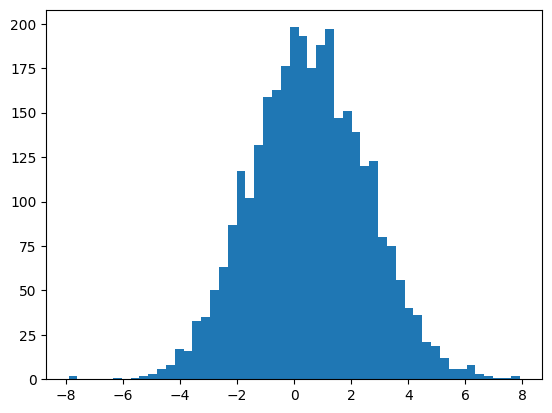

In [229]:
fig, ax = plt.subplots()
ax.hist(trade_results, bins=51)

So now that we have some "domain knowledge", we need to choose which values of `threshold` to measure. First, we'll use domain knowledge to limit the credible values, then we'll make sure to measure enough values to satisfy the requirements of the analysis stage.

#### Limit the range of parameter values with domain knowledge

While you probably don't know the optimal value right off the bat, you can still use your domain knowledge to inform your decision. In our case, we know that `signal` is standard normal (in a real system, you might know the mean and standard deviation because you've made lots of trades). That allows us to make some conclusions:
1. `threshold >= 0`. If not, then the BUY and SELL actions would be valid at the same time.
1. `signal` will take on a value > 2 only 5% of the time. Thus, we can reasonably limit our credible value to <= 2.

Thus, using our domain knowledge, we expect `0 < threshold < 2`.

#### Continuous parameters in RSM

Our analysis step can estimate `markout_profit` at unmeasured values of `threshold` due to its continuous nature. Some other types of parameters:

1. Categorical: one that takes on a few arbitrary values. For instance, when `exchange` could be one of `NASDAQ` or `NYSE`, it was a categorical variable. There's no natural ordering to these.
1. Discrete (ordinal): A parameter that takes on integer values. They are ordered. For instance, a `num_orders` parameter might take on a value 1, 2, or 3.
1. Continuous: A parameter that takes on real (in the mathematical sense) values. Ordered.

The variable `markout\_profit` is also continuous and varies continusouly with `threshold`. This allows us to use *interpolation* to estimate values of `markout\_profit` at values of `threshold` that we haven't actually measured, as long as we've measured ones that are reasonably close.

#### Interpolation over Continuous Parameters

$$
\begin{align*}
\text{threshold\_1} &= 1 \\
\text{threshold\_2} &= 2 \\
\text{markout\_profit}(\text{threshold\_1}) &= 5 \\
\text{markout\_profit}(\text{threshold\_2}) &= 6 \\
\end{align*}
$$

Estimate:

$\text{threshold\_mid} = (\text{threshold\_1} + \text{threshold\_2}) / 2 = 1.5$

$\text{markout\_profit}(\text{threshold\_mid}) = (\text{markout\_profit}(\text{threshold\_1}) + \text{markout\_profit}(\text{threshold\_2})) / 2 = 5.5$

(Linear interpolation between the two points (`threshold_1`, `markout_profit(threshold_1)`) and (`threshold_2`, `markout_profit(threshold_2)`)

With two measurements, we're going to draw a line. That means that our maximum will (almost) always be one of the endpoints - the measured vlues. However, we can take a third measurement $\to$ fit a parabola betwen them. This works because at a maximum, whatever the function it is will resemble the vertex of a parabola, letting us get reasonably accurate measurements.

Since for us we constrained `0 < threshold < 2`, we might take measurements at 0.5, 1, and 1.5.

#### Determine the number of individual measurements

We want to randomly assign trades to one of `threshold=0.5, 1, 1.5`. We randomize here for the same reason as in A/B testing - to remove bias. We can determine the number of replications to use by treating each value as the "B" version of a system.

Measure the `sd_delta`. We kind of already did that when we simulated the system - `sd_1_delta = 1.2`.

Next we want the practical significance. Since in the simulation we have a mean profit of 0.17, we could take a percentage of that (say, 20%) as our level of practical significance: `prac_sig=0.2 * 0.17 = 0.03`.

Then the number of measurements is

In [230]:
sd_1_delta = 1.2
prac_sig = 0.2 * 0.17
num_ind = (2.48 * sd_1_delta / prac_sig) ** 2
num_ind

7661.39792387543

One difference btween this and A/B testing - here we're testing three different versions. That means that we need to slightly change the way that we deal with false positives. For now, we'll just slightly increase the number of tests that we take:

In [231]:
num_ind = (3.08 * 1.2 / 0.03) ** 2
num_ind

15178.239999999998

### Take the measurements

Now it's time to make the trades. We'll simulate the experiment with the `run_experiment` function.

In [232]:
def run_experiment(num_ind, thresholds):
    individual_measurements = {threshold: [] for threshold in thresholds}
    done = set()
    while True:
        threshold = np.random.choice(thresholds)
        profit = markout_profit(threshold)
        individual_measurements[threshold].append(profit)
        if len(individual_measurements[threshold]) >= num_ind:
            done.add(threshold)
        if len(done) == len(thresholds):
            break
            
    aggregate_measurements = []
    standard_errors = []
    for threshold in thresholds:
        ims = np.array(individual_measurements[threshold])
        aggregate_measurements.append(ims.mean())
        standard_errors.append(ims.std() / np.sqrt(len(ims)))
    
    return aggregate_measurements, standard_errors

In [233]:
np.random.seed(17)
thresholds = np.array([0.5, 1, 1.5])
aggregate_measurements, standard_errors = run_experiment(15_000, thresholds)

In [234]:
aggregate_measurements, standard_errors

([0.09848496576216006, 0.1711214205711533, 0.13699263220703944],
 [0.013267765976681866, 0.00957041724519083, 0.006796544642991194])

<ErrorbarContainer object of 3 artists>

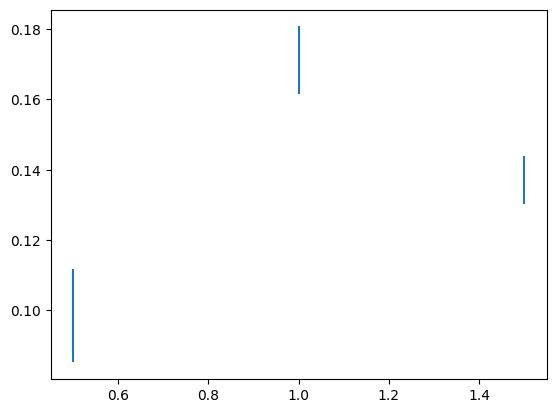

In [235]:
fig, ax = plt.subplots()
ax.errorbar(thresholds, aggregate_measurements, standard_errors, linestyle='')

### Analyze 1: Interpolate between measurements

First, we specify the model:

$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \epsilon
$$

In terms of the values from the experiment,

$$
y = \begin{pmatrix} 
    0.098 \\
    0.0171 \\
    0.137 \\
\end{pmatrix}
$$

$$
\beta = \begin{pmatrix}
    \beta_0 \\
    \beta_1 \\
    \beta_2 \\
\end{pmatrix}
$$

$$
X = \begin{pmatrix}
    1 & 0.5 & 0.5^2 \\
    1 & 1 & 1^2 \\
    1 & 1.5 & 1.5^2 \\
\end{pmatrix}
$$

Then

$$
y = X\beta + \epsilon
$$

The solution to this is given by the normal equations

$$ \beta = \left( X^T X\right)^{-1} (X^T y)$$

In [236]:
def linear_regressions(thresholds, aggregate_measurements):
    x = thresholds
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x, x**2]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta

---
Matrix operations in `numpy`

- $X^T$ $\to$ `X.T`
- Matrix product $AB \to$ `A @ B`
- Matrix / vector product $Ax \to$ `A @ x`
- Dot product $x \cdot y $ or $x^T y$ $\to$ `x.T @ y`
- Matrix inverse: $X^{-1} \to$ `np.linalg.inv(X)`
---

Now we'll use the values we got to estimate values where we did not take any measurements. The array of thresholds is $\hat{x}$ (`xhat`), and the interpolated values are $\hat{y} = \hat{X}\beta$ (`yhat = XHat @ beta`)

In [237]:
def interpolate(thresholds, beta):
    xhat = np.arange(thresholds.min(), thresholds.max() + 1e-6, 0.1) # the 1e6 just ensures that the endpoint is included
    XHat = np.array([np.ones(len(xhat)), xhat, xhat ** 2]).T
    yhat = XHat @ beta
    return xhat, yhat

In [238]:
beta = linear_regressions(thresholds, aggregate_measurements)
beta

array([-0.08091673,  0.46556864, -0.21353049])

In [239]:
xhat, yhat = interpolate(thresholds, beta)

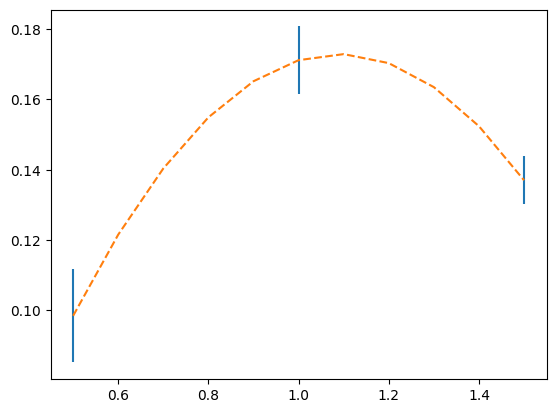

In [240]:
fig, ax = plt.subplots()
ax.errorbar(thresholds, aggregate_measurements, standard_errors, linestyle='')
ax.plot(xhat, yhat, linestyle='--')

This suggests a maximum around 1.1 or 1.2 ish.

### Analyze II: Optimize the business metric

Now we just need to find the value of `xhat` which optimzes `yhat`!

In [241]:
def optimize(thresholds, beta):
    xhat, yhat = interpolate(thresholds, beta)
    i = np.where(yhat == yhat.max())[0][0]
    return xhat[i], yhat[i]

In [242]:
# whole process:
beta = linear_regressions(thresholds, aggregate_measurements)
threshold_opt, estimated_max_profit = optimize(thresholds, beta)
threshold_opt, estimated_max_profit

(1.0999999999999999, 0.17283688235218303)

So this is our process!

1. Measure stage: took aggregate measurements of business metrics at each parameter value
2. Analyze stage:
    1. Interpolate: fit a model (parabola) of the business metric as a function of the parameter (here, profit as a function of threshold) using a linear regression
    2. Optimize: using the model, calculate the value of the parameter which results in the largest profit
    
### Validate the optimal parameter value

So now we have an estimate of the optimal value. However, we still need to validate it! For that, we should measure the profit at that new value nd ensure that it's actually higher than at the other values we considered.

#### A simple validation measurement

Take the validation measurement the same way that we did he initial measurements: `num_ind = (3.08 * 1.2 / 0.03 ) ** 2` $\approx$ `15 000` measurements with the parameter set to the optimal value, then compute the aggregate measurement (mean) and its standard error.

Recall that the standard error will be 

$$
SE = \frac{\text{stddev}(\text{individual measurements})}{\sqrt{N}}
$$

We consider the results valid if $\text{agregrate measurement} - 2 * \text{SE} < \text{estimated max profit} < \text{aggregate measurement} + 2 * \text{SE}$. This is because the aggregate is approximately normal with a sd given by the SE. Thus, making sure that it lies within two standard deviations of the measured value gives us the 95% confidence interval, and so we say that if the measurement is outside of this value, there is only a 5% chance that we were incorrectly declaring the interpolation invalid.

In [243]:
np.random.seed(17)
aggregate_measurements, standard_error = run_experiment(15_000, [threshold_opt])
print(aggregate_measurements[0] - 2 * standard_error[0], aggregate_measurements[0] + 2 * standard_error[0])

0.1419316310326502 0.17734089466810063


Since our measured optimum value (0.173) falls in this range, we consider it valid! 

If it weren't valid, we would need to investigat further. It may be that a parabola is not a good approximation in the area. You may need to shrink the interval of consideration and try again.

#### A more robust valiadtion measurement

This process is generally good, but for lots of systems, the measurements can drift over time. This is called **nonstationarity**, and it'll be considered in more depth later. This drift can make it so that noncontemporaneous measurements can't be compared. In particular, the `threshold_opt` that we measured might have been different had we measured it earlier or later.

Also, the RSM procedure is more complicated compared to a simple A/B test, meaning that we might have more errors. We accept that risk because of the increased speed / efficiency.

Thus, a better way of validating our estimated optimal value would be to run an A/B test of the new value against the old one. When designing the A/B test, we need to specify `prac_sig`; for us, a good value would be `prac_sig = estimated_max_profit - markout_profit_A`, where `markout_profit_A` is the current markout profit of the system running as is. Basically, this says that the test should be sensitive enough to capture the estimated difference you expect to see.

This was the process for one continuous parameter - now let's modify it to accept more than one!

## Optimizing two or more continuous parameters

We can use RSM to optimize over any number of continuous parameters, although it is best suited for three or fewer.

Previously, we optimized over just one parameter: `threshold`, which determined how strong the BUY / SELL signal needed to be for us to take action. Now we might want to optimize over the *size* of the order as well. For instance, maybe earlier you bought $\$$1000 worth of stock at each time. Now, you want to increase that. However, you can't always place these orders - people might not be willing to sell in that quantity. Ironically, you find it easier to buy / sell when the market is about to move against you - an example of *adverse selection*, and the profit lost to it is *adverse selection cost*.

If you keep the order size too small, you'll miss out on profit. Too high, and the adverse selection costs will be too high! Where's the optimum?

We'll update the `markout_profit` function to take the `order_size` in thousands of dollars. We'll model the adverse selection costs as

$$
\text{asc} = 0.001 \times e^{2\times \text{order size}}
$$

The number of tuneable parameters in a system is the number of *dimensions*.

In [244]:
def markout_profit_2D(threshold, order_size):
    cost = 1 # cost to trade
    pps = 1 # profit per signal
    asc = 0.001 * np.exp(2 * order_size)
    signal = np.random.normal()
    epsilon = np.random.normal()
    profit = 0
    if signal > threshold or signal < -threshold:
        profit = order_size * (pps * np.abs(signal) - cost + epsilon) - asc
    return profit

### Design the two-parameter experiment

Now we need to decide on the combination of values of `threshold` and `order_size` to optimize over. In the 1D case, we needed three measurements to fit the parabola. A similar reasoning applies here - we need three values for `threshold` and three for `order_size`, giving us 9 different combinations. This is called *face-centred central composite design*.

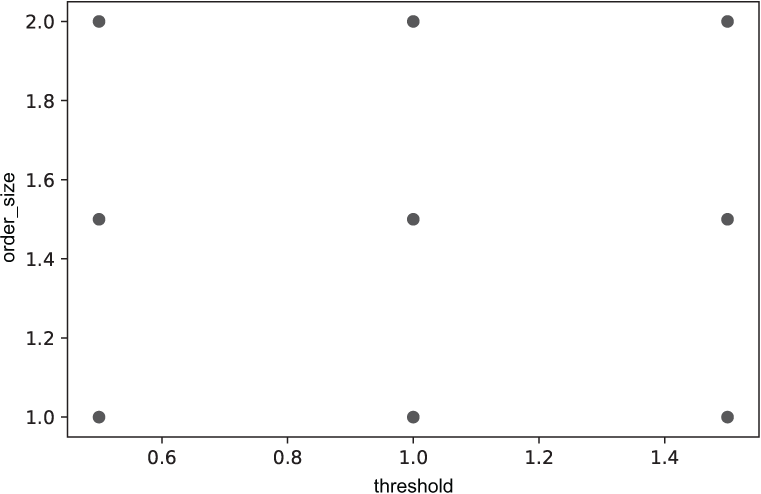

In [245]:
def design_ccd(thresholds, order_sizes):
    parameters = [
        (threshold, order_size) for threshold in thresholds for order_size in order_sizes
    ]
    return parameters

In [246]:
parameters = design_ccd(thresholds=[0.5, 1, 1.5], order_sizes=[1, 1.5, 2])
parameters

[(0.5, 1),
 (0.5, 1.5),
 (0.5, 2),
 (1, 1),
 (1, 1.5),
 (1, 2),
 (1.5, 1),
 (1.5, 1.5),
 (1.5, 2)]

Now we need to decide how many measurements we need to take. Same idea as before: `prac_sig=0.2 * 0.17` $\approx$ `0.03` $\to$

$$
\text{num\_ind} = (3.08 * 1.2 / 0.03) ^ 2 \approx 15 000
$$

We assumed that our system can make about 10 000 trades per day. Since we have 9 things to test, we need about $9 \times 15 000 / 10000 \approx 14$ days. Not totally unreasonable, but there are ways to make it faster.

### Measure, Analyze, and Validate the 2D Experiment

Same basic idea, just slightly modified to accommodate the extra dimension.

In [247]:
def run_experiment_2D(num_ind, parameters):
    individual_measurements = {
        parameter: [] for parameter in parameters
    }
    done = set()
    while True:
        parameter = random.choice(parameters)
        threshold, order_size = parameter
        profit = markout_profit_2D(threshold=threshold, order_size=order_size)
        individual_measurements[parameter].append(profit)
        if len(individual_measurements[parameter]) >= num_ind:
            done.add(parameter)
        if len(done) == len(individual_measurements):
            break
    aggregate_measurements = []
    standard_errors = []
    for parameter in parameters:
        ims = np.array(individual_measurements[parameter])
        aggregate_measurements.append(ims.mean())
        standard_errors.append(ims.std() / np.sqrt(len(ims)))

    return aggregate_measurements, standard_error

In [248]:
np.random.seed(17)
parameters = design_ccd(thresholds=[0.5, 1, 1.5], order_sizes=[1, 1.5, 2])
aggregate_measurements, standard_errors = run_experiment_2D(15_000, parameters)
parameters

[(0.5, 1),
 (0.5, 1.5),
 (0.5, 2),
 (1, 1),
 (1, 1.5),
 (1, 2),
 (1.5, 1),
 (1.5, 1.5),
 (1.5, 2)]

<ErrorbarContainer object of 3 artists>

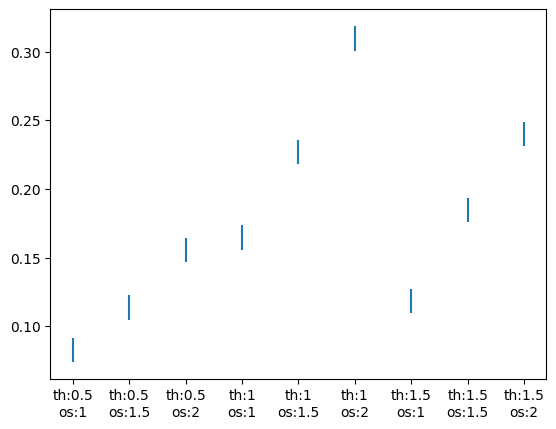

In [249]:
fig, ax = plt.subplots()
labels = [ f"th:{threshold}\nos:{order_size}" for threshold, order_size in parameters ]
ax.errorbar(labels, aggregate_measurements, standard_errors, linestyle='')


This looks promising, but a bit hard to interpret.

#### Analyze the Experiment

Now we'll use linear regression to build a model of the aggregate measurements of markout profit. Our model with two parameters will be

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1^2 + \beta_4 x_2^2 + \beta_5 x_1 x_2 + \epsilon
$$

In [250]:
def linear_regression_2D(parameters, aggregate_measurements):
    """ Use the same formula as before for linear regression """
    parameters = np.array(parameters)
    x0 = parameters[:,0] # thresholds
    x1 = parameters[:,1] # order sizes
    y = aggregate_measurements
    X = np.array([np.ones(len(y)), x0, x1, x0 ** 2, x1 ** 2, x0 * x1]).T
    beta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return beta

In [251]:
beta = linear_regression_2D(parameters=parameters, aggregate_measurements=aggregate_measurements)

In [252]:
def interpolate_2D(parameters, beta):
    parameters = np.array(parameters)
    x0_values = np.arange(parameters[:,0].min(), parameters[:,0].max() + 1e-6, 0.01)
    x1_values = np.arange(parameters[:,1].min(), parameters[:,1].max() + 1e-6, 0.01)
    x0hat_2d, x1hat_2d = np.meshgrid(x0_values, x1_values)
    x0hat = x0hat_2d.flatten()
    x1hat = x1hat_2d.flatten()
    XHat = np.array([np.ones(len(x0hat)), x0hat, x1hat, x0hat ** 2, x1hat ** 2, x0hat * x1hat]).T
    yhat = XHat @ beta
    yhat_2d = np.reshape(yhat, (len(x1_values), len(x0_values)))
    return x0hat_2d, x1hat_2d, yhat_2d

In [253]:
def optimize_2d(parameters, beta):
    x0hat, x1hat, yhat = interpolate_2D(parameters=parameters, beta=beta)
    i = np.where(yhat == yhat.max())
    return x0hat[i][0], x1hat[i][0], yhat[i][0]

In [254]:
beta = linear_regression_2D(parameters, aggregate_measurements)
threshold_opt, order_size_opt, estimated_max_profit = optimize_2d(parameters, beta)
threshold_opt, order_size_opt, estimated_max_profit

(1.1300000000000006, 2.000000000000001, 0.297231848639389)

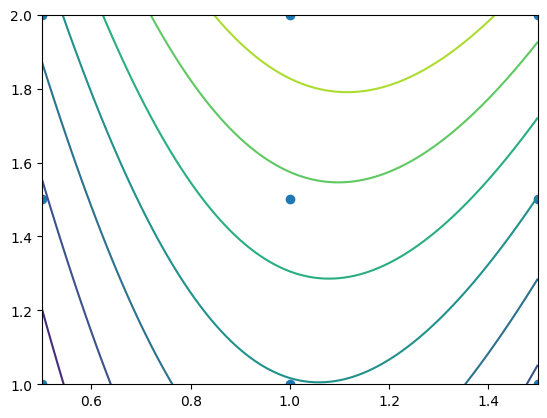

In [255]:
x0hat_2d, x1hat_2d, yhat_2d = interpolate_2D(parameters, beta)
fig, ax = plt.subplots()
ax.contour( x0hat_2d, x1hat_2d , yhat_2d)
ax.scatter([parameter[0] for parameter in parameters], [parameter[1] for parameter in parameters])

Here we can see that the maximum happens right near the edge - we have a low confidence that this is actually correct. We need to take more real-world measurements centred on our estimated maximum value.

In [256]:
parameters = design_ccd(thresholds=[0.5, 1, 1.5], order_sizes=[2.5, 3, 3.5])
aggregate_measurements, standard_errors = run_experiment_2D(15_000, parameters)
beta = linear_regression_2D(parameters, aggregate_measurements)
threshold_opt, order_size_opt, estimated_max_profit = optimize_2d(parameters, beta)

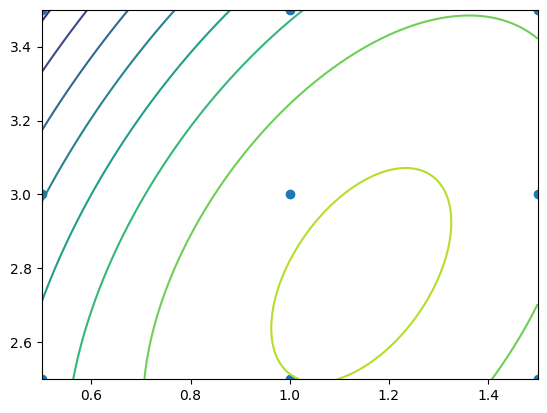

In [257]:

x0hat_2d, x1hat_2d, yhat_2d = interpolate_2D(parameters, beta)
fig, ax = plt.subplots()
ax.contour( x0hat_2d, x1hat_2d , yhat_2d)
ax.scatter([parameter[0] for parameter in parameters], [parameter[1] for parameter in parameters])

<ErrorbarContainer object of 3 artists>

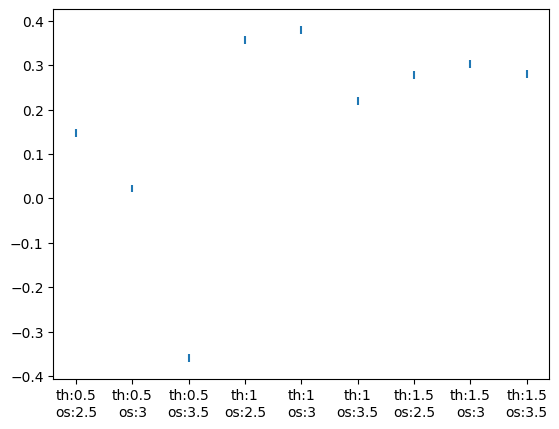

In [258]:

fig, ax = plt.subplots()
labels = [ f"th:{threshold}\nos:{order_size}" for threshold, order_size in parameters ]
ax.errorbar(labels, aggregate_measurements, standard_errors, linestyle='')

Here we have one measurement that is really far away from the others - this shouldn't happen if we are in fact checking values near our optimum. It might be that the shape of the function is too complex to be adequately captured by a parabola (or paraboloid, in this case). The solution is to shrink our parameter values in towards the centre and iterate.

In [259]:

np.random.seed(17)
parameters = design_ccd(thresholds=[0.75, 1, 1.25], order_sizes=[2.75, 3, 3.25])
aggregate_measurements, standard_errors = run_experiment_2D(15_000, parameters)
beta = linear_regression_2D(parameters, aggregate_measurements)
threshold_opt, order_size_opt, estimated_max_profit = optimize_2d(parameters, beta)

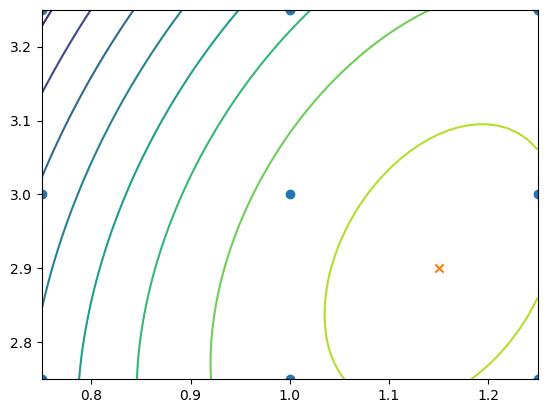

In [260]:

x0hat_2d, x1hat_2d, yhat_2d = interpolate_2D(parameters, beta)
fig, ax = plt.subplots()
ax.contour( x0hat_2d, x1hat_2d, yhat_2d)
ax.scatter([parameter[0] for parameter in parameters], [parameter[1] for parameter in parameters])
ax.scatter([threshold_opt], [order_size_opt], marker='x')

<ErrorbarContainer object of 3 artists>

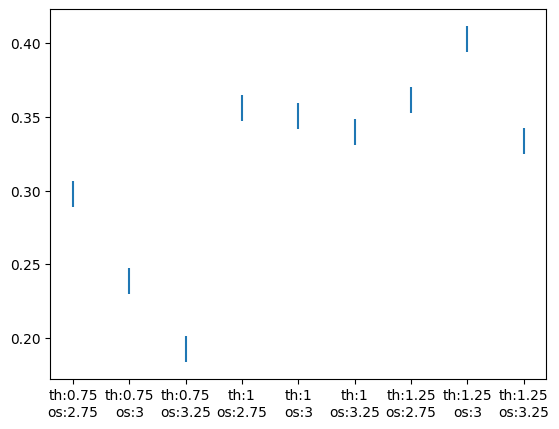

In [261]:

fig, ax = plt.subplots()
labels = [ f"th:{threshold}\nos:{order_size}" for threshold, order_size in parameters ]
ax.errorbar(labels, aggregate_measurements, standard_errors, linestyle='')

This seems far more reasonable!

Now we check to see whether the estimated value falls in the 95% CI:

In [262]:
aggregate_measurements, standard_errors = run_experiment_2D(num_ind=15_000, parameters=[(threshold_opt, order_size_opt)])
aggregate_measurement = aggregate_measurements[0]
standard_error = standard_errors[0]
(aggregate_measurement - 2 * standard_error, aggregate_measurement + 2 * standard_error)

(0.35457469156398747, 0.38998395519943796)

In [263]:
estimated_max_profit

0.38359702507014926

So our estimated value falls within the 95% CI!